# Reconocimiento de vocales

## Estandarización del formato de los audios capturados a `.wav`.

Por defecto:
* Whatsapp: `*.ogg`
* Grabadora de voz win10: `*.m4a`

In [5]:
# importa librerias y define rutas
import os 
import glob
import librosa
import soundfile 

CURRENT_PATH = os.getcwd()
SAMPLES_PATH = os.path.join(CURRENT_PATH, 'database')


In [ ]:
# Transforma todos los audios a formato .wav
# capturar ambiente de colab y correr. 

import warnings
warnings.filterwarnings("ignore")

for format in ['ogg', 'm4a']:
    for vowel in ['a', 'e', 'i', 'o', 'u'][0]:
        # absolute path to search all text files inside a specific folder
        path = os.path.join(SAMPLES_PATH, f'{vowel}', f'*.{format}')
        #print(path)
        files = glob.glob(path)
        #print(files)
        i = 1
        for file in files:
          print("in for cycle for change format")
          audio, sr = librosa.load(str(file), sr = 16000)
          #soundfile.write("test file.wav", audio ,16000)
          soundfile.write(os.path.join(SAMPLES_PATH, f'{vowel}', f'{vowel}t_({i}).wav'), audio ,16000)
          i+=1            

          if os.path.exists(file):
            print(f"file {file} deleted!")
            os.remove(file)           

## Cargando un archivo de audio

In [3]:
import librosa

audio_path = os.path.join(SAMPLES_PATH, 'a', 'a (1).wav')
audio, sr = librosa.load(audio_path)

## Reproduciendo el audio

In [3]:
import IPython.display as ipd

ipd.Audio(audio_path) # no se puede reproducir en vscode :/

## Visualizando el audio

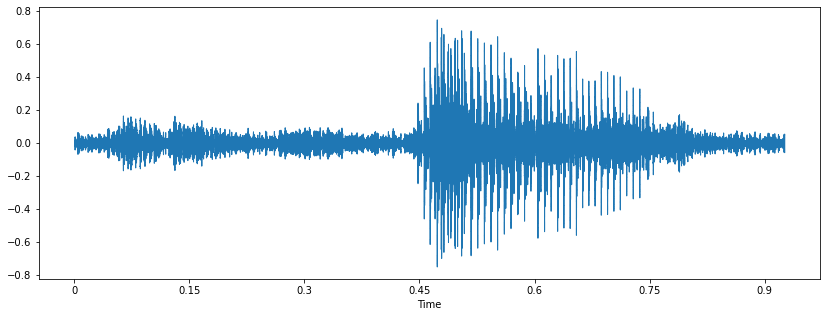

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr) # cambiar waveplot por waveshow, para librosa>=0.9

## Generando el espectograma

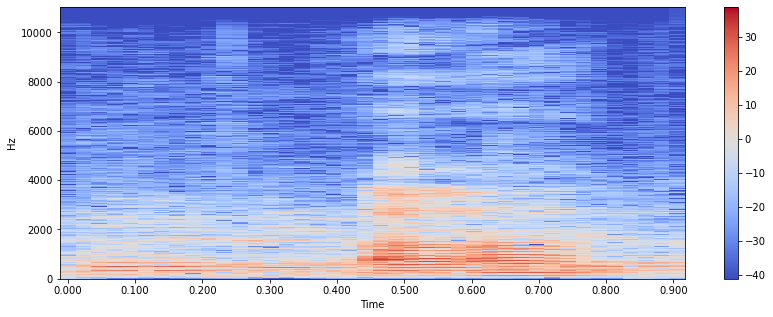

In [10]:
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

# Extracción de propiedades del audio

## Centroide espectral

/home/cgaravitoc/miniconda3/envs/py47/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.01348155  0.01802139  0.01482143 ... -0.0445425  -0.03583177
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


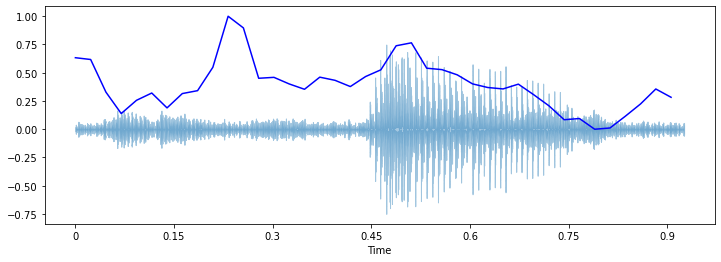

In [15]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sr)[0]
spectral_centroids.shape
#(775,)

# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(audio, axis=0):
    return sklearn.preprocessing.minmax_scale(audio, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(audio, sr=sr, alpha=0.4) # cambiar waveplot por waveshow
plt.plot(t, normalize(spectral_centroids), color='b')

## Spectral rolloff

/home/cgaravitoc/miniconda3/envs/py47/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass y=[ 0.02348155  0.02802139  0.02482143 ... -0.0345425  -0.02583177
  0.01      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


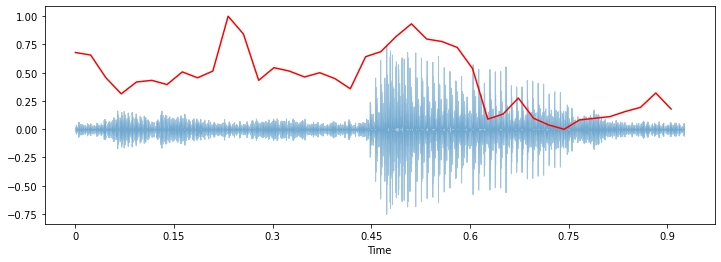

In [17]:
spectral_rolloff = librosa.feature.spectral_rolloff(audio+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))

librosa.display.waveshow(audio, sr=sr, alpha=0.4) # waveshow
plt.plot(t, normalize(spectral_rolloff), color='r')

## Ancho de banda espectral

/home/cgaravitoc/miniconda3/envs/py47/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass y=[ 0.02348155  0.02802139  0.02482143 ... -0.0345425  -0.02583177
  0.01      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.
/home/cgaravitoc/miniconda3/envs/py47/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.02348155  0.02802139  0.02482143 ... -0.0345425  -0.02583177
  0.01      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/home/cgaravitoc/miniconda3/envs/py47/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Pass y=[ 0.02348155  0.02802139  0.02482143 ... -0.0345425  -0.02583177
  0.01      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  This is separate from the ipykernel package so we can avoid doing imports unti

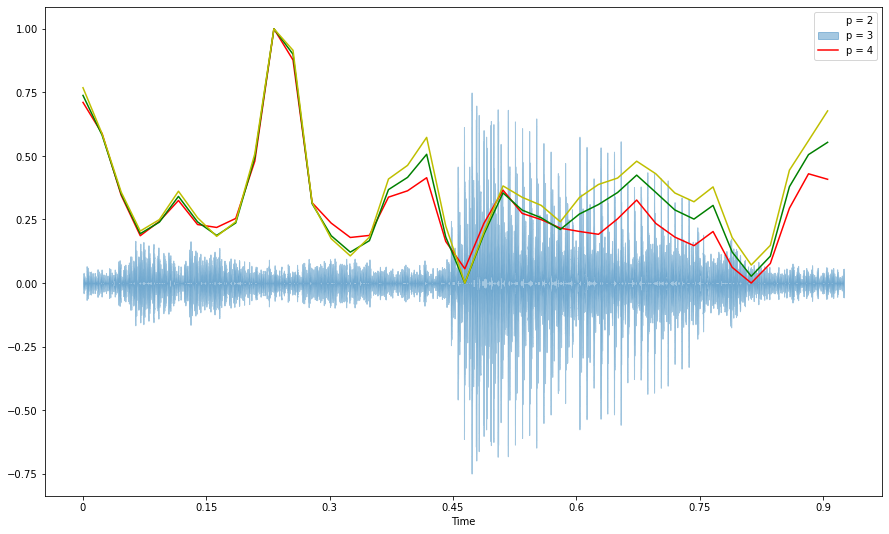

In [19]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(audio+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(audio+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(audio+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))

librosa.display.waveshow(audio, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

## Zero-Crossing Rate

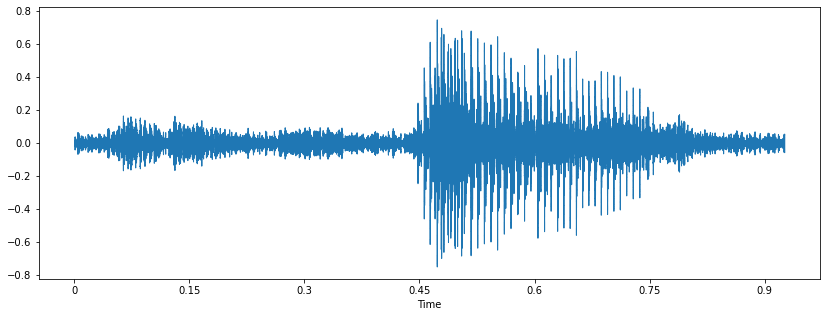

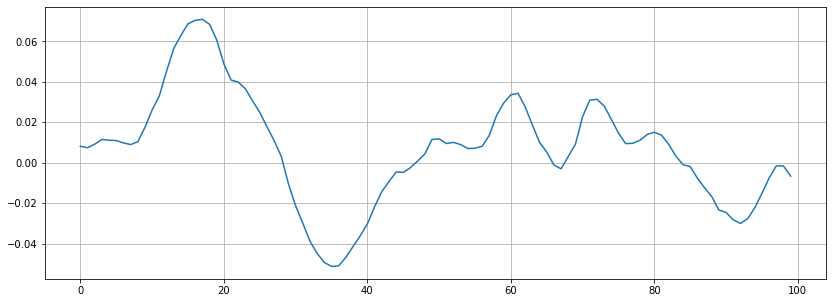

In [21]:
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(audio[n0:n1])
plt.grid()

## Mel-Frequency Cepstral Coefficients(MFCCs)

(20, 40)


/home/cgaravitoc/miniconda3/envs/py47/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass y=[ 0.01348155  0.01802139  0.01482143 ... -0.0445425  -0.03583177
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


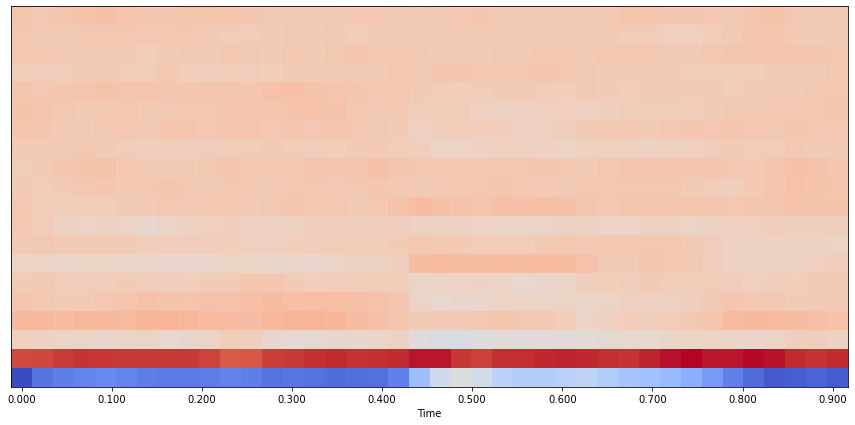

In [23]:
mfccs = librosa.feature.mfcc(audio, sr=sr)
print(mfccs.shape)
#(20, 97)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## Chroma feature

/home/cgaravitoc/miniconda3/envs/py47/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass y=[ 0.01348155  0.01802139  0.01482143 ... -0.0445425  -0.03583177
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


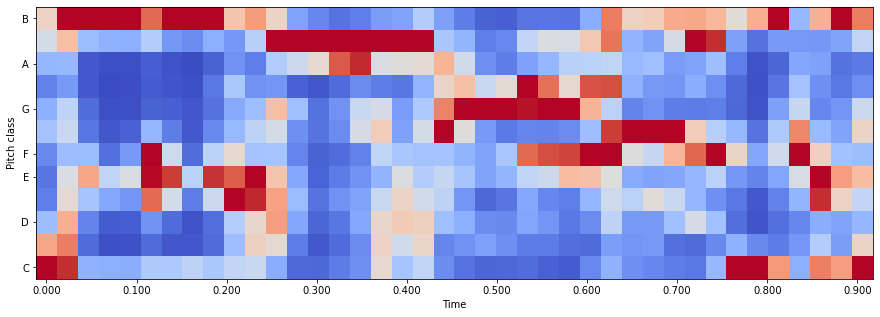

In [27]:
chromagram = librosa.feature.chroma_stft(audio, sr=sr, hop_length=512) # hop_lengt 512 según ejemplo
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

# Referencias

[Sound Visualization](https://maelfabien.github.io/machinelearning/Speech10/#)

[Vibration Analysis: FFT, PSD, and Spectrogram Basics](https://blog.endaq.com/vibration-analysis-fft-psd-and-spectrogram)

[The Power Spectrum](https://mark-kramer.github.io/Case-Studies-Python/03.html)

[Formate](https://es.wikipedia.org/wiki/Formante)

[Las características acústicas de los elementos segmentales](http://liceu.uab.es/~joaquim/phonetics/fon_anal_acus/caract_acust.html): Acá hay una imagen de los espectrogramas de las vocales, en donde se identifican los formantes. 

[Audio Deep Learning Made Simple: Sound Classification, Step-by-Step](https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5)

[Introduction to Audio Classification](https://www.analyticsvidhya.com/blog/2021/06/introduction-to-audio-classification/)

[Audio Data Analysis Using Deep Learning with Python (Part 1)](https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html)